# Air Pollution in Algeria

## Methodology

This analysis examines NO2 (nitrogen dioxide) pollution levels across Algeria from 2019-2025 using satellite data from the Sentinel-5P TROPOMI instrument via Google Earth Engine. We processed monthly NO2 column number density measurements at high spatial resolution, matched monitoring points to administrative boundaries (provinces and districts), and aggregated the data to identify pollution patterns. Special attention was given to areas near gas flaring sites, where we analyzed the relationship between NO2 concentrations and nighttime lights as a proxy for economic activity. The analysis reveals temporal trends, spatial distributions, and regional variations in air quality across Algeria.

In [8]:
# import os

# # Set the GOOGLE_APPLICATION_CREDENTIALS environment variable to your JSON file
# os.environ['GOOGLE_APPLICATION_CREDENTIALS'] = '../../training-253313-c905674c1ca0.json'

# # Check if the file exists
# if os.path.exists(os.environ['GOOGLE_APPLICATION_CREDENTIALS']):
#     print(f"Credentials file found: {os.environ['GOOGLE_APPLICATION_CREDENTIALS']}")
# else:
    
#     print(f"WARNING: Credentials file not found at {os.environ['GOOGLE_APPLICATION_CREDENTIALS']}")
    
# # This environment variable tells the Google Cloud libraries where to find your credentials
# print("GOOGLE_APPLICATION_CREDENTIALS environment variable has been set.")

In [9]:
# from airpollutionpy import downloadgcs
# downloadgcs.download_bucket_files(output_folder='../data/airpollution/', 
#                       bucket_name='datalab-air-pollution',
#                       prefix='DZA/ADM2/')

In [ ]:
import pandas as pd
import glob
import geopandas as gpd
import matplotlib.pyplot as plt

import ast
import json
from utils import *
from visuals import *

In [4]:
from pathlib import Path
DATA_PATH = Path("../../data")
NO2_DATA_PATH = DATA_PATH / "airpollution"
BOUNDARY_DATA_PATH = DATA_PATH / "boundaries" 

In [5]:
def extract_coordinates(x):
	try:
		if isinstance(x, dict):
			return (x.get('coordinates'))
		elif isinstance(x, str):
			return (json.loads(x)['coordinates'])
		else:
			return None
	except Exception:
		return None

In [6]:
from concurrent.futures import ProcessPoolExecutor, as_completed
from multiprocessing import cpu_count
import time


In [7]:
# Alternative: Ultra-fast version with threading for I/O
from concurrent.futures import ThreadPoolExecutor
import pandas as pd
import time 
import glob

def process_single_file_optimized(file_path):
    """
    Optimized version with faster coordinate extraction
    """
    try:
        # Use faster CSV reading
        df = pd.read_csv(file_path, low_memory=False)
        
        # Vectorized coordinate extraction (much faster than apply)
        df['coordinates'] = df['.geo'].apply(extract_coordinates)
        df['longitude'] = df['coordinates'].apply(lambda coords: coords[0] if coords else None)
        df['latitude'] = df['coordinates'].apply(lambda coords: coords[1] if coords else None)
        
        # Drop columns and parse dates
        df = df.drop(columns=['.geo', 'coordinates', 'system:index'])
        df['start_date'] = pd.to_datetime(df['start_date'])
        df['source_file'] = file_path.split('/')[-1]
        
        #print(f"✓ {file_path.split('/')[-1]}: {df.shape[0]} rows")
        return df
    except Exception as e:
        #print(f"✗ Error with {file_path}: {e}")
        return pd.DataFrame()

# Get list of files for this optimized version
files = list(glob.glob(str(NO2_DATA_PATH / '*.csv')))
#print(f"Found {len(files)} CSV files to process")

# For I/O heavy tasks, ThreadPoolExecutor can be faster than ProcessPoolExecutor
print("Using optimized threading version...")
start_time = time.time()

dataframes = []
with ThreadPoolExecutor(max_workers=min(32, len(files))) as executor:
    futures = [executor.submit(process_single_file_optimized, file) for file in files]
    
    for future in as_completed(futures):
        df = future.result()
        if not df.empty:
            dataframes.append(df)

if dataframes:
    no2_optimized = pd.concat(dataframes, ignore_index=True)
    print(f"\n🚀 Optimized processing completed!")
    print(f"⏱️  Processing time: {time.time() - start_time:.1f} seconds")
    print(f"📊 Final shape: {no2_optimized.shape}")
    print(f"📁 Files processed: {len(dataframes)}/{len(files)}")
else:
    no2_optimized = pd.DataFrame()

Using optimized threading version...

🚀 Optimized processing completed!
⏱️  Processing time: 419.8 seconds
📊 Final shape: (192068930, 9)
📁 Files processed: 9313/9313

🚀 Optimized processing completed!
⏱️  Processing time: 419.8 seconds
📊 Final shape: (192068930, 9)
📁 Files processed: 9313/9313


In [36]:
#no2_optimized.to_csv('../../data/airpollution/no2_raw.csv')


In [12]:
unique_points = no2_optimized[['latitude', 'longitude']].drop_duplicates()

unique_points = gpd.GeoDataFrame(unique_points,
                                    geometry=gpd.points_from_xy(unique_points.longitude, unique_points.latitude))
unique_points.crs = "EPSG:4326"

In [219]:
dza_adm0 = gpd.read_file(BOUNDARY_DATA_PATH / 'geoBoundaries-DZA-ADM0.geojson')
dza_adm1 = gpd.read_file(BOUNDARY_DATA_PATH / 'gadm41_DZA_1.json')
dza_adm2 = gpd.read_file(BOUNDARY_DATA_PATH / "gadm41_DZA_2.json")
dza_adm3 = gpd.read_file(BOUNDARY_DATA_PATH / 'DZA_ADM3_gbOpen.geojson')

In [266]:
# For points that matched multiple polygons, pick the one where point is furthest from boundary
def pick_deepest_polygon(group, polygon_gdf):
    """
    For a point matching multiple polygons, pick the one furthest from the boundary
    
    Args:
        group: DataFrame group with duplicate point-polygon matches
        polygon_gdf: The original polygon GeoDataFrame to get geometries from
    """
    if len(group) == 1:
        return group

    # Get the point geometry
    point = group.iloc[0].geometry
    
    # Calculate distance from point to each matched polygon's boundary
    distances = []
    for idx, row in group.iterrows():
        try:
            # Get the polygon geometry from the original GeoDataFrame using GID_2
            polygon_match = polygon_gdf[polygon_gdf['GID_2'] == row['GID_2']]
            
            if len(polygon_match) == 0:
                # If no match found, assign very small distance (will be deprioritized)
                distances.append(0.0)
                continue
                
            polygon = polygon_match.iloc[0].geometry
            
            # Calculate distance from point to polygon boundary
            dist_to_boundary = point.distance(polygon.boundary)
            distances.append(dist_to_boundary)
        except Exception as e:
            # If any error, assign 0 distance
            print(f"Error processing GID_2={row['GID_2']}: {e}")
            distances.append(0.0)

    # Return the row with maximum distance to boundary (deepest inside)
    if max(distances) > 0:
        deepest_idx = distances.index(max(distances))
        return group.iloc[[deepest_idx]]
    else:
        # If all distances are 0, just return the first one
        return group.iloc[[0]]


# # Group by the original point index and pick the deepest polygon for each
# result = merged.groupby(level=0, group_keys=False).apply(pick_deepest_polygon)

# print(f"Original matches: {len(merged)}, After deduplication: {len(result)}")
# print(result[["latitude", "longitude", "ADM3_PCODE"]].head())

In [308]:
merged = unique_points[['geometry', 'latitude', 'longitude']].sjoin(
    dza_adm2[['GID_1','NAME_1','GID_2','NAME_2', 'geometry']], 
    how='left', 
    predicate='within'
)

In [295]:
unique_points.shape

(2624718, 3)

In [309]:
merged.shape

(2624825, 8)

In [324]:
# points on the boundaries aren't mapped to their respective admin regions

unmatched_mask = merged['GID_2'].isna()

# Get the actual lat/lon of unmatched points from merged (not unique_points!)
unmatched_coords = merged[unmatched_mask][['latitude', 'longitude']].drop_duplicates()
unmatched_points = gpd.GeoDataFrame(
    unmatched_coords,
    geometry=gpd.points_from_xy(unmatched_coords.longitude, unmatched_coords.latitude),
    crs="EPSG:4326"
)

print(f"Points matched with 'within': {(~unmatched_mask).sum()}")
print(f"Unique unmatched points (likely on borders): {len(unmatched_points)}")

# Step 3: For unmatched points, find nearest admin region
if len(unmatched_points) > 0:
    # Use sjoin_nearest to find closest polygon
    nearest_matches = unmatched_points[['geometry', 'latitude', 'longitude']].sjoin_nearest(
         dza_adm2[['GID_1','NAME_1','GID_2','NAME_2', 'geometry']], 
        how='left',
        max_distance=0.065,  # 1.5km distance
        distance_col='distance_to_boundary'
    )
    
    # Combine the results
    # First, keep all the 'within' matches
    merged_complete = merged[~unmatched_mask].copy()
    
    # Then add the nearest matches for border points
    nearest_matches['match_type'] = 'nearest'
    merged_complete['match_type'] = 'within'
    
    merged_complete = pd.concat([merged_complete, nearest_matches], ignore_index=True)
    
    print(f"\nAfter nearest join:")
    print(f"Total matched points: {merged_complete['GID_2'].notna().sum()}")
    print(f"Still unmatched: {merged_complete['GID_2'].isna().sum()}")
    print(f"Unique points in merged_complete: {merged_complete[['latitude', 'longitude']].drop_duplicates().shape[0]}")
    print(f"\nMatch type breakdown:")
    print(merged_complete['match_type'].value_counts())
else:
    merged_complete = merged.copy()
    merged_complete['match_type'] = 'within'

# Update the result variable
merged_complete = gpd.GeoDataFrame(merged_complete, geometry='geometry', crs="EPSG:4326")

# Final verification
print(f"\n✓ Started with {len(unique_points)} unique points")
print(f"✓ Ended with {merged_complete[['latitude', 'longitude']].drop_duplicates().shape[0]} unique points in merged_complete")
print(f"✓ Lost points: {len(unique_points) - merged_complete[['latitude', 'longitude']].drop_duplicates().shape[0]}")

Points matched with 'within': 2621720
Unique unmatched points (likely on borders): 3105


/Users/ssarva/algeria-economic-monitoring/.venv/lib/python3.13/site-packages/geopandas/array.py:408: UserWarning: Geometry is in a geographic CRS. Results from 'sjoin_nearest' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  warnings.warn(



After nearest join:
Total matched points: 2624827
Still unmatched: 0
Unique points in merged_complete: 2624718

Match type breakdown:
match_type
within     2621720
nearest       3107
Name: count, dtype: int64

✓ Started with 2624718 unique points
✓ Ended with 2624718 unique points in merged_complete
✓ Lost points: 0
✓ Ended with 2624718 unique points in merged_complete
✓ Lost points: 0


In [325]:
unique_points.shape[0]


2624718

In [326]:
merged[['latitude', 'longitude']].drop_duplicates().shape

(2624718, 2)

In [327]:
merged_complete[['latitude', 'longitude']].drop_duplicates().shape

(2624718, 2)

In [328]:
# Apply deduplication ONLY to points with multiple polygon matches
print("\n--- Deduplication Step ---")
print(f"Before deduplication: {len(merged_complete)} rows")
print(f"Unique points: {merged_complete[['latitude', 'longitude']].drop_duplicates().shape[0]}")

# Identify which points have duplicates
point_counts = merged_complete.groupby(['latitude', 'longitude']).size()
duplicate_points = point_counts[point_counts > 1].index

print(f"Points with multiple polygon matches: {len(duplicate_points)}")
print(f"Total duplicate rows: {point_counts[point_counts > 1].sum() - len(duplicate_points)}")

# Split into duplicates and non-duplicates
has_duplicates = merged_complete.set_index(['latitude', 'longitude']).index.isin(duplicate_points)
duplicated_rows = merged_complete[has_duplicates].copy()
unique_rows = merged_complete[~has_duplicates].copy()

print(f"\nRows to deduplicate: {len(duplicated_rows)}")
print(f"Already unique rows: {len(unique_rows)}")

# Only apply deduplication to the duplicated rows
if len(duplicated_rows) > 0:
    deduplicated_rows = duplicated_rows.groupby(['latitude', 'longitude'], group_keys=False).apply(
        lambda g: pick_deepest_polygon(g, dza_adm2)
    ).reset_index(drop=True)
    
    # Combine deduplicated rows with already-unique rows
    result = pd.concat([unique_rows, deduplicated_rows], ignore_index=True)
else:
    result = unique_rows.copy()

print(f"\nAfter deduplication: {len(result)} rows")
print(f"Points removed: {len(merged_complete) - len(result)}")
print(f"Unique points in result: {result[['latitude', 'longitude']].drop_duplicates().shape[0]}")

# Verify no duplicates remain
duplicates_check = result.groupby(['latitude', 'longitude']).size()
remaining_duplicates = duplicates_check[duplicates_check > 1]
print(f"Remaining duplicate points: {len(remaining_duplicates)}")

if len(remaining_duplicates) > 0:
    print("\n⚠️  Sample of remaining duplicates:")
    sample_dup = remaining_duplicates.head()
    for (lat, lon), count in sample_dup.items():
        print(f"  Point ({lat:.6f}, {lon:.6f}): {count} matches")
        print(result[(result['latitude'] == lat) & (result['longitude'] == lon)][['NAME_1', 'NAME_2', 'GID_2', 'match_type']])


--- Deduplication Step ---
Before deduplication: 2624827 rows
Unique points: 2624718
Points with multiple polygon matches: 109
Total duplicate rows: 109
Points with multiple polygon matches: 109
Total duplicate rows: 109

Rows to deduplicate: 218
Already unique rows: 2624609

After deduplication: 2624718 rows
Points removed: 109

Rows to deduplicate: 218
Already unique rows: 2624609

After deduplication: 2624718 rows
Points removed: 109


/var/folders/gs/_227cnyd0pq1fr817_0jbcyw0000gp/T/ipykernel_31968/583974536.py:23: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  deduplicated_rows = duplicated_rows.groupby(['latitude', 'longitude'], group_keys=False).apply(


Unique points in result: 2624718
Remaining duplicate points: 0


In [330]:
result.shape[0] - unique_points.shape[0]

0

In [270]:
# Check if there are any latitude longitude points mapped to more than one ShapeID
df = merged.groupby(['latitude', 'longitude'])['GID_2'].nunique().reset_index()
df[df['GID_2']>1]['GID_2'].sum()

np.int64(214)

In [331]:
# Check if there are any latitude longitude points mapped to more than one ShapeID
df = result.groupby(['latitude', 'longitude'])['GID_2'].nunique().reset_index()
df[df['GID_2']>1]

,latitude,longitude,GID_2


In [332]:
no2 = no2_optimized[['latitude', 'longitude', 'start_date', 'month', 'year','NO2_column_number_density']]

In [333]:
no2_adm3 = no2.merge(result, on =['latitude', 'longitude'], how='inner')

In [431]:
no2_optimized[no2_optimized['year']==2025][['latitude', 'longitude']].drop_duplicates().shape

(1005749, 2)

In [442]:
set(no2_adm3_annual[no2_adm3_annual['year']==2024]['NAME_2'].unique()) - set(no2_adm3_annual[no2_adm3_annual['year']==2025]['NAME_2'].unique())


{'Ain-Legradj',
 'Arzew',
 'BadredineElMokrani',
 'Beni-Aziz',
 'BeniChebana',
 'BordjElHaouasse',
 'Djanet',
 'DjendelSaadiMohamed',
 'Draa-Kebila',
 'Filfila',
 'FoggaretAzzouia',
 'Gdyel',
 'Idles',
 'InGuezzam',
 'Kanoua',
 'KhengMaoun',
 'Lemtar',
 'Ouanougha',
 'OuledAttia',
 'OuledTebben',
 'Serdj-El-Ghoul',
 'SidiAliBoussidi',
 'SidiBenYebka',
 'Tamenghasset',
 'Tazrouk',
 'TinZaouatine'}

In [395]:
# Aggregate NO2 values by administrative region (ADM3)
# no2_adm3_agg = no2_adm3.groupby(['GID_1', 'NAME_1', 'GID_2','NAME_2','start_date', 'month']).agg({
#     'NO2_column_number_density': ['mean', 'min', 'max', 'sum', 'std', 'count']
# }).reset_index()

# # Flatten column names
# no2_adm3_agg.columns = ['GID_1', 'NAME_1', 'GID_2','NAME_2', 'start_date','month','NO2_mean', 'NO2_min', 'NO2_max', 'NO2_sum', 'NO2_std', 'record_count']

# Aggregate NO2 values by administrative region (ADM3)
no2_adm3_annual = no2_adm3.groupby(['GID_1', 'NAME_1', 'GID_2','NAME_2','year']).agg({
    'NO2_column_number_density': ['mean', 'min', 'max', 'sum', 'std', 'count']
}).reset_index()

# Flatten column names
no2_adm3_annual.columns = ['GID_1', 'NAME_1', 'GID_2','NAME_2', 'year','NO2_mean', 'NO2_min', 'NO2_max', 'NO2_sum', 'NO2_std', 'record_count']


In [422]:
no2_adm3[no2_adm3['year']==2025]['NAME_2'].nunique()

1369

In [493]:
no2_adm1_agg = no2_adm3.groupby(['GID_1', 'NAME_1','start_date', 'month', 'year']).agg({
    'NO2_column_number_density': ['mean', 'min', 'max', 'sum', 'std', 'count']
}).reset_index()

# Flatten column names
no2_adm1_agg.columns = ['GID_1', 'NAME_1', 'start_date','month','year','NO2_mean', 'NO2_min', 'NO2_max', 'NO2_sum', 'NO2_std', 'record_count']

no2_adm1_annual = no2_adm3.groupby(['GID_1', 'NAME_1','year']).agg({
    'NO2_column_number_density': ['mean', 'min', 'max', 'sum', 'std', 'count']
}).reset_index()

# Flatten column names
no2_adm1_annual.columns = ['GID_1', 'NAME_1','year','NO2_mean', 'NO2_min', 'NO2_max', 'NO2_sum', 'NO2_std', 'record_count']

In [494]:
no2_adm1_agg['NAME_0']= 'Algeria'

In [496]:
no2_adm1_agg.columns

Index(['GID_1', 'NAME_1', 'start_date', 'month', 'year', 'NO2_mean', 'NO2_min',
       'NO2_max', 'NO2_sum', 'NO2_std', 'record_count', 'NAME_0'],
      dtype='object')

In [641]:
no2_adm0_monthly = no2_adm1_agg.groupby(['NAME_0','start_date', 'month', 'year'])[['NO2_mean', 'NO2_min',
       'NO2_max', 'NO2_sum', 'NO2_std']].mean().reset_index()

# Flatten column names
#no2_adm0_monthly.columns = ['start_date','month','year','NO2_mean', 'NO2_min', 'NO2_max', 'NO2_sum', 'NO2_std', 'record_count']

#no2_adm0_monthly['NAME_0'] = 'Algeria'


no2_adm0_annual = no2_adm1_agg.groupby(['NAME_0', 'year'])[['NO2_mean', 'NO2_min',
       'NO2_max', 'NO2_sum', 'NO2_std']].mean().reset_index()

# Flatten column names
# no2_adm0_annual.columns = ['year','NO2_mean', 'NO2_min', 'NO2_max', 'NO2_sum', 'NO2_std', 'record_count']

# no2_adm0_annual['NAME_0'] = 'Algeria'

## National Trends in NO2

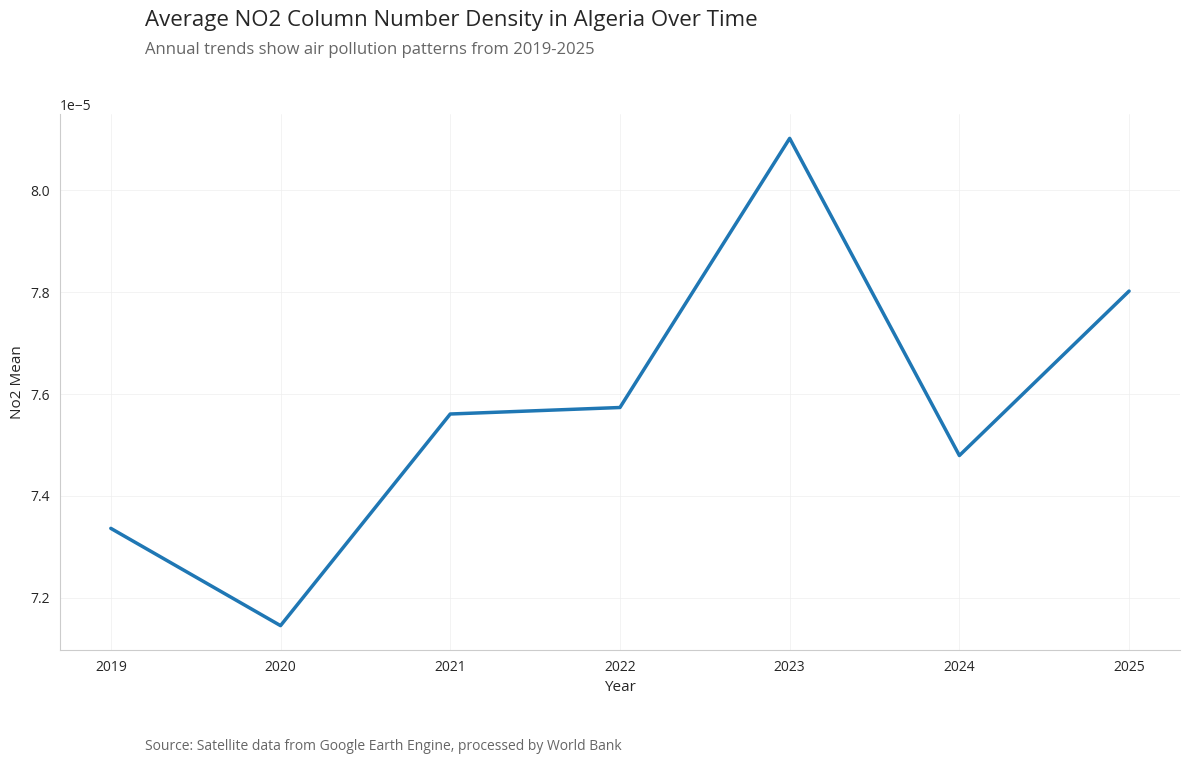

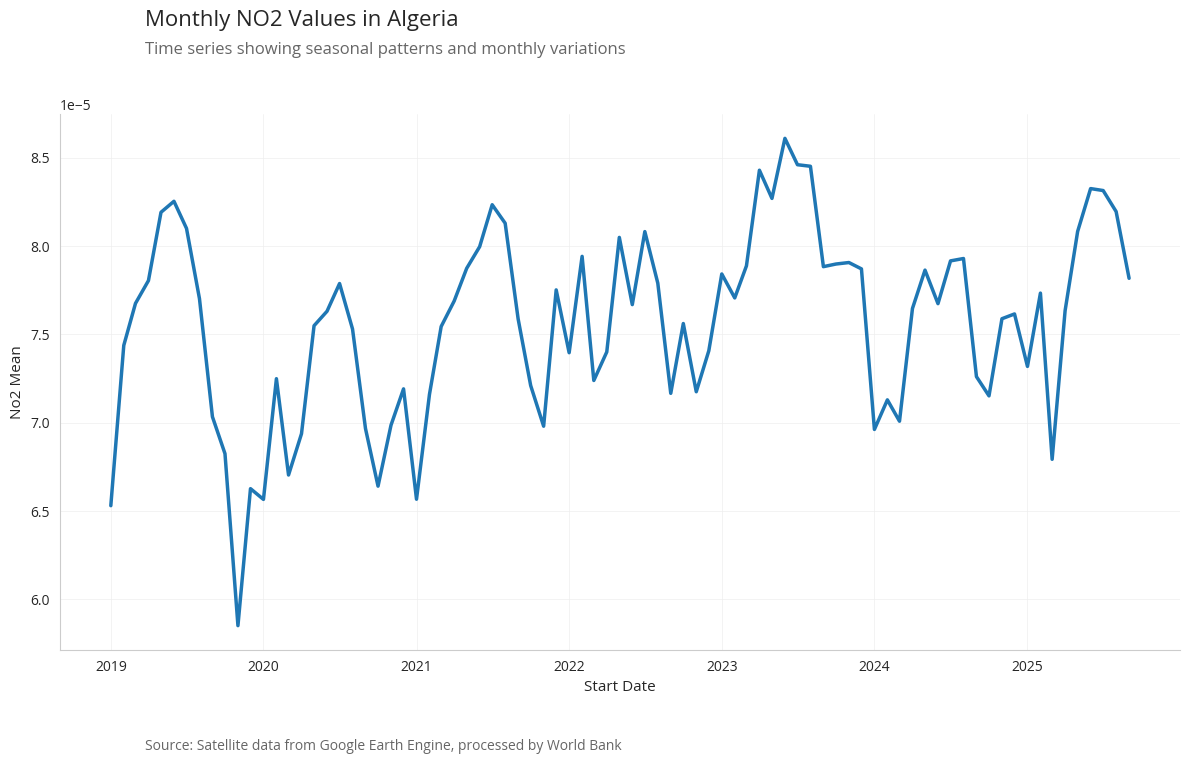

In [671]:
%reload_ext autoreload
%autoreload 2

from visuals import *

#print("🎨 Creating World Bank styled charts...")

# Plot using World Bank styling - with improved fallback
plot_wb_styled(
    data=no2_adm0_annual,
    x_column='year',
    y_column='NO2_mean',
    category_column='NAME_0',
    title='Average NO2 Column Number Density in Algeria Over Time',
    subtitle='Annual trends show air pollution patterns from 2019-2025',
    source_note='Satellite data from Google Earth Engine, processed by World Bank'
)

plot_wb_styled(
    data=no2_adm0_monthly,
    x_column='start_date',
    y_column='NO2_mean',
    category_column='NAME_0',
    title='Monthly NO2 Values in Algeria',
    subtitle='Time series showing seasonal patterns and monthly variations',
    source_note='Satellite data from Google Earth Engine, processed by World Bank'
);

## Wilaya Trends in NO2

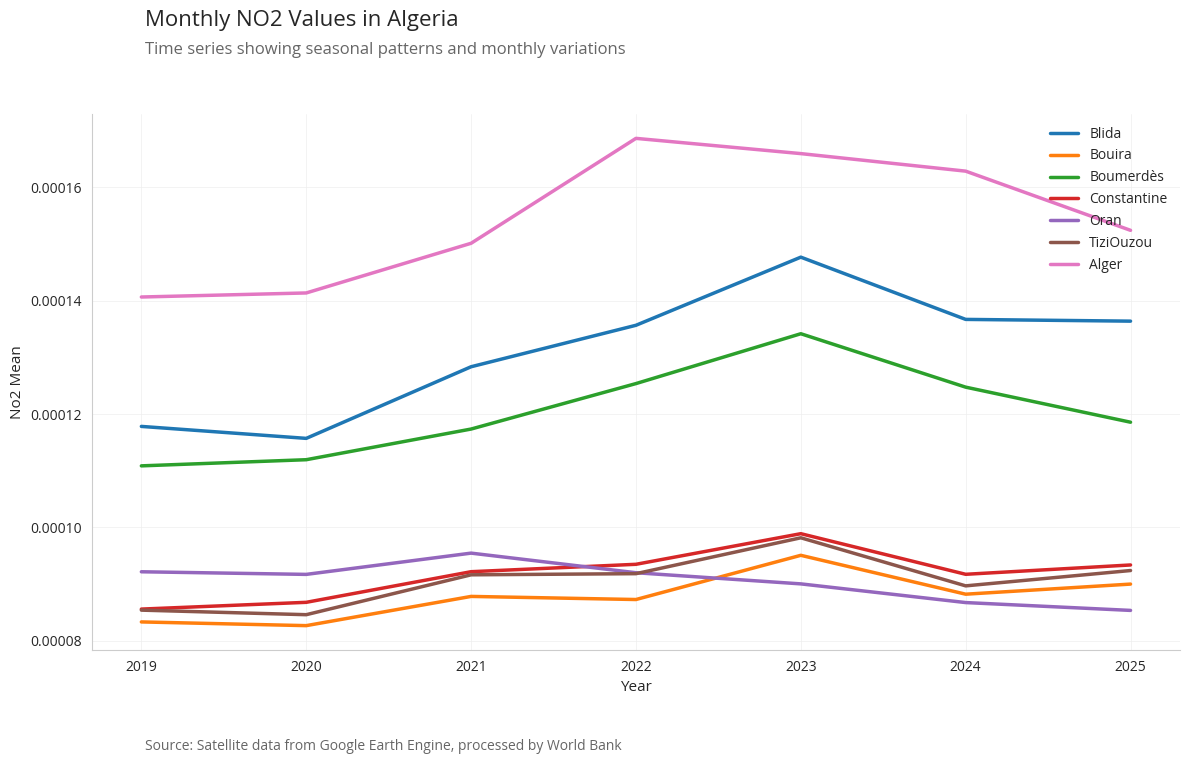

In [ ]:


# Plot the time series
plot_wb_styled(
    data=no2_adm1_annual[no2_adm1_annual['NAME_1'].isin(top_emittors)],
    x_column='year',
    y_column='NO2_mean',
    category_column='NAME_1',
    title='Annual NO2 Values by Province in Algeria',
    subtitle='Yearly trends in top emitting provinces, 2019-2025',
    source_note='Satellite data from Google Earth Engine, processed by World Bank'
);


In [503]:
#no2_adm3_agg_gdf = dza_adm2.merge(no2_adm3_agg, on = ['GID_1', 'GID_2', 'NAME_1', 'NAME_2'])
#no2_adm3_annual_gdf = dza_adm2.merge(no2_adm3_annual, on = ['GID_1', 'GID_2', 'NAME_1', 'NAME_2'])
no2_adm1_annual_gdf = dza_adm1.merge(no2_adm1_annual, on = ['GID_1', 'NAME_1'])

/Users/ssarva/algeria-economic-monitoring/notebooks/emissions/visuals.py:98: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  # Axis labels


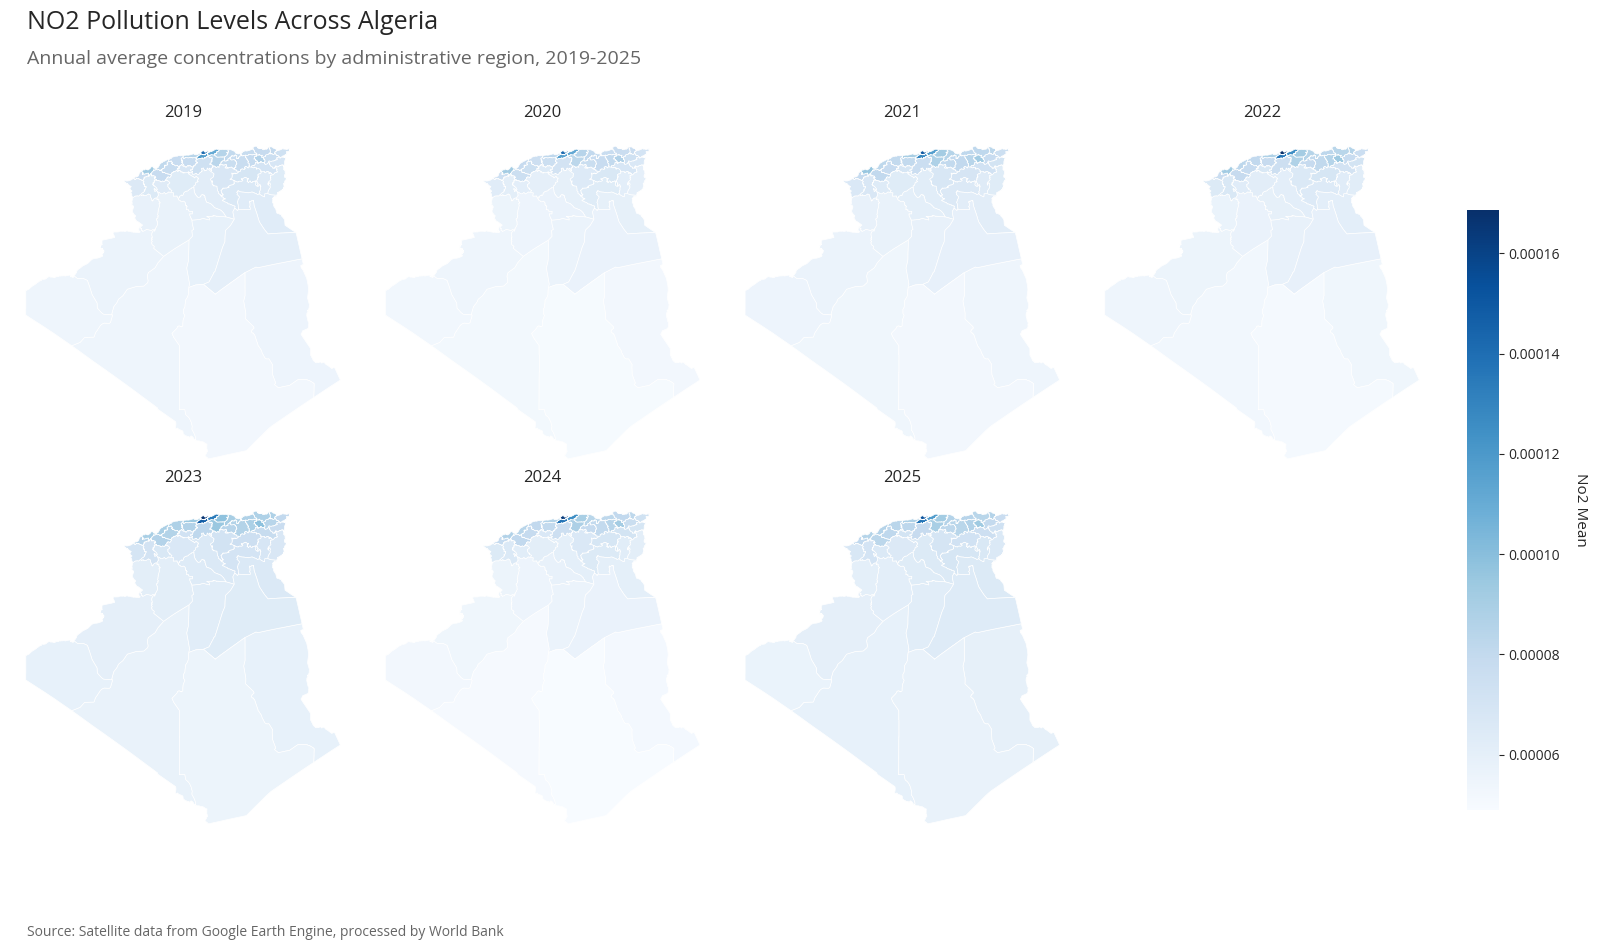

In [611]:
plot_comparative_maps_over_time(no2_adm1_annual_gdf,
                                  value_column='NO2_mean',
                                  category_column='year',
                                  title='NO2 Pollution Levels Across Algeria',
                                  subtitle='Annual average concentrations by administrative region, 2019-2025',
                                  source_note='Source: Satellite data from Google Earth Engine, processed by World Bank',
                                  cmap='Blues',
                                  figsize_per_map=(4, 4),
                                  max_cols=4,
                                  show_colorbar=True,
                                  boundary_color='white',
                                  boundary_linewidth=0.5,
                                  #save_path: Optional[str] = None,

);

### Pollution in Alger

/Users/ssarva/algeria-economic-monitoring/notebooks/emissions/visuals.py:98: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  # Axis labels
/Users/ssarva/algeria-economic-monitoring/notebooks/emissions/visuals.py:98: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  # Axis labels


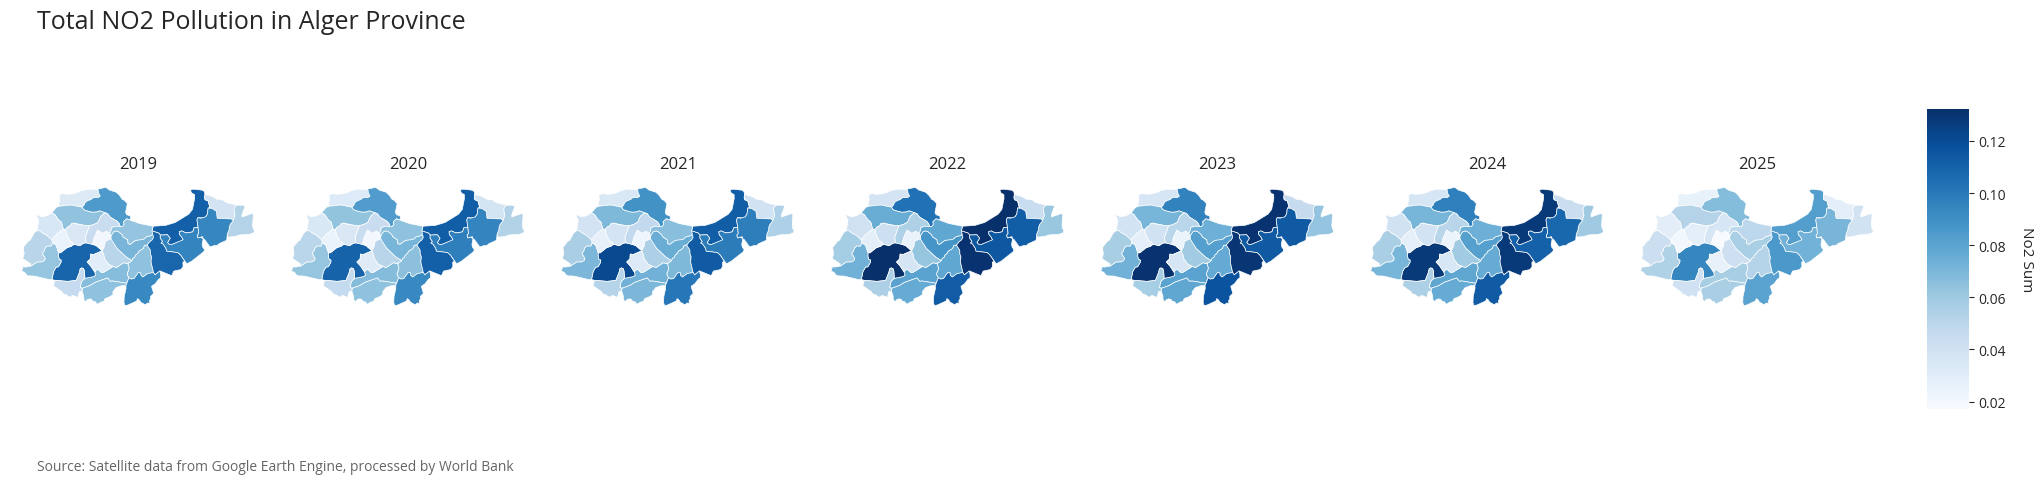

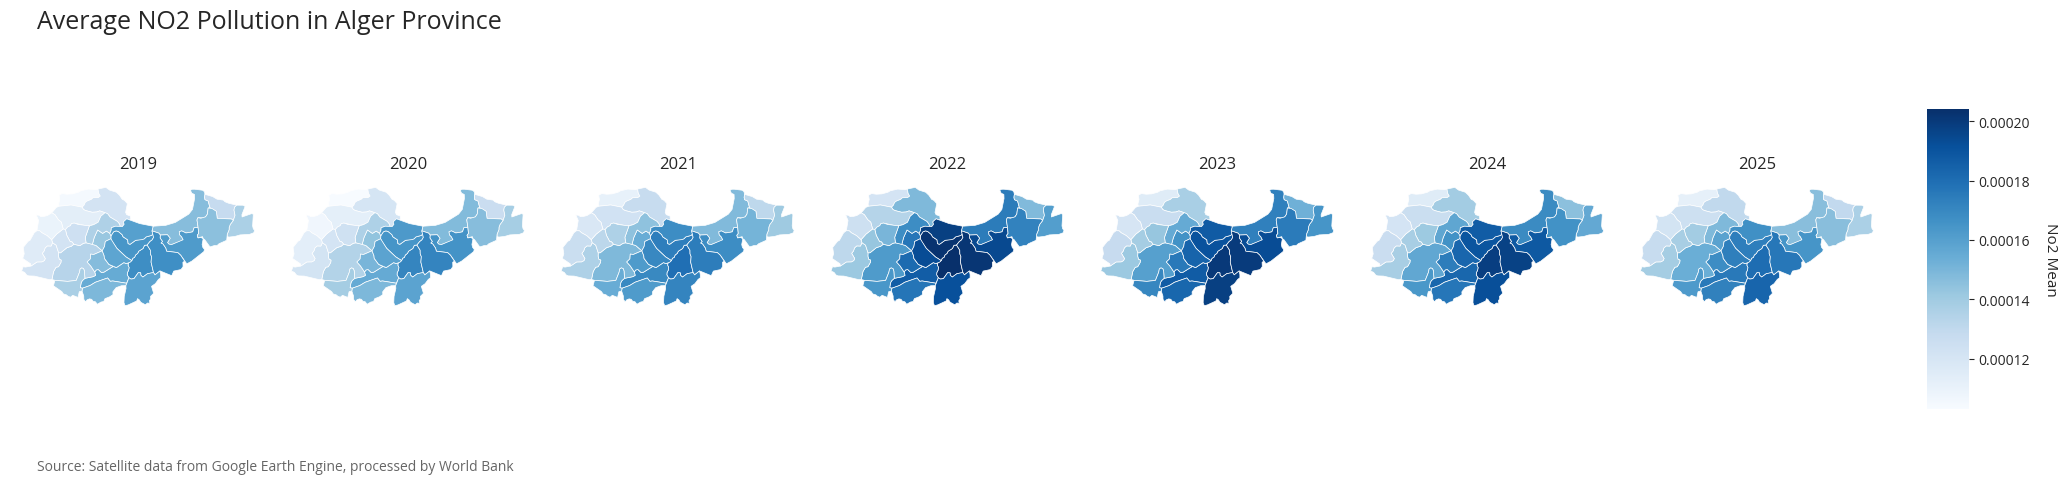

In [651]:
plot_comparative_maps_over_time(no2_adm3_annual_gdf[no2_adm3_annual_gdf['NAME_1'].isin(['Alger'])],
                                  value_column='NO2_sum',
                                  category_column='year',
                                  title='Total NO2 Pollution in Alger Province',
                                  subtitle='',
                                  source_note='Source: Satellite data from Google Earth Engine, processed by World Bank',
                                  cmap='Blues',
                                  figsize_per_map=(3, 3),
                                  max_cols=7,
                                  show_colorbar=True,
                                  boundary_color='white',
                                  boundary_linewidth=0.5,
                                  #save_path: Optional[str] = None,

);

plot_comparative_maps_over_time(no2_adm3_annual_gdf[no2_adm3_annual_gdf['NAME_1'].isin(['Alger'])],
                                  value_column='NO2_mean',
                                  category_column='year',
                                  title='Average NO2 Pollution in Alger Province',
                                  subtitle='',
                                  source_note='Source: Satellite data from Google Earth Engine, processed by World Bank',
                                  cmap='Blues',
                                  figsize_per_map=(3, 3),
                                  max_cols=7,
                                  show_colorbar=True,
                                  boundary_color='white',
                                  boundary_linewidth=0.5,
                                  #save_path: Optional[str] = None,

);

## Pollution in Gas Flaring Locations

In [540]:
import pyreadr

# Read gas flaring locations from RDS file
gas_flaring_path = DATA_PATH / "gas-flaring" / "gas_flare_locations.Rds"
result = pyreadr.read_r(str(gas_flaring_path))

# RDS files return a dictionary, get the dataframe (usually the first key)
gas_flaring_locations = result[None]  # None is the default key for single dataframes

print(f"Gas flaring locations shape: {gas_flaring_locations.shape}")
print(f"\nColumns: {gas_flaring_locations.columns.tolist()}")
print(f"\nFirst few rows:")
gas_flaring_locations.head()

Gas flaring locations shape: (1035, 3)

Columns: ['latitude', 'longitude', 'uid']

First few rows:


,latitude,longitude,uid
0,31.662874,6.056340,1
1,28.735950,9.789314,2
2,31.590504,5.958267,3
3,28.684193,7.194338,4
4,31.685301,6.188873,5


In [576]:
# Create GeoDataFrame from gas flaring locations
gas_flaring_10km = gpd.GeoDataFrame(
    gas_flaring_locations, 
    geometry=gpd.points_from_xy(gas_flaring_locations.longitude, gas_flaring_locations.latitude)
)
gas_flaring_10km.crs = "EPSG:4326"

# Project to UTM Zone 31N (suitable for Algeria) for accurate distance calculations
# UTM uses meters, making it appropriate for buffering
gas_flaring_10km_utm = gas_flaring_10km.to_crs("EPSG:32631")

# Create 10km (10,000 meters) buffer
gas_flaring_10km_utm['geometry'] = gas_flaring_10km_utm.buffer(10000)

# Project back to WGS84 for compatibility with other datasets
gas_flaring_10km = gas_flaring_10km_utm.to_crs("EPSG:4326")

print(f"Gas flaring locations with 10km buffer: {len(gas_flaring_10km)} features")
print(f"CRS: {gas_flaring_10km.crs}")
gas_flaring_10km.head()

Gas flaring locations with 10km buffer: 1035 features
CRS: EPSG:4326


,latitude,longitude,uid,geometry
0,31.662874,6.056340,1,"POLYGON ((6.16167 31.66031, 6.16086 31.65149, ..."
1,28.735950,9.789314,2,"POLYGON ((9.89099 28.73078, 9.88992 28.72202, ..."
2,31.590504,5.958267,3,"POLYGON ((6.06352 31.58802, 6.06273 31.5792, 6..."
3,28.684193,7.194338,4,"POLYGON ((7.29641 28.68099, 7.29556 28.67218, ..."
4,31.685301,6.188873,5,"POLYGON ((6.29421 31.68262, 6.29339 31.67381, ..."


In [577]:
gas_flaring_10km = gas_flaring_10km.sjoin(dza_adm2[['GID_1','NAME_1','GID_2','NAME_2', 'geometry']], how='inner', predicate='intersects')

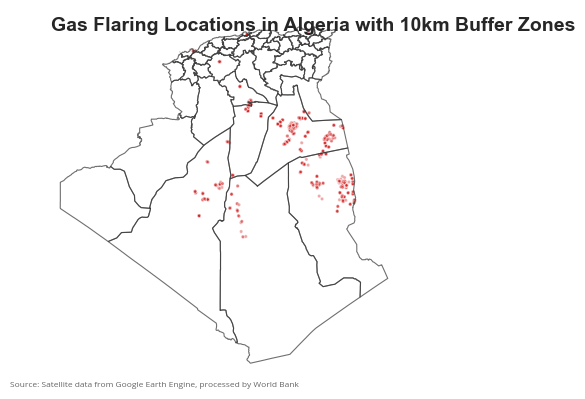

In [687]:
# Create a formatted map showing gas flaring locations with 10km buffer zones
fig, ax = plt.subplots(figsize=(6, 4))

# Plot provincial boundaries
dza_adm1.boundary.plot(ax=ax, linewidth=0.8, edgecolor='#333333', alpha=0.7)

# Plot gas flaring buffer zones with transparency
gas_flaring_10km.plot(ax=ax, color='#d62728', alpha=0.4, linewidth=0.5)

# Add title
ax.text(0.02, 0.98, 'Gas Flaring Locations in Algeria with 10km Buffer Zones',
        transform=ax.transAxes, fontsize=14, weight='bold',
        verticalalignment='top', fontfamily='sans-serif')

# Remove axes
ax.set_axis_off()

# Add source note at bottom
fig.text(0.02, 0.02, 'Source: Satellite data from Google Earth Engine, processed by World Bank',
         fontsize=6, style='italic', color='#666666')

plt.tight_layout()
plt.show()

In [681]:
# Spatial join to find points within 10km of gas flaring locations
gas_flaring_points = unique_points.sjoin(gas_flaring_10km[['geometry', 'uid', 'GID_1', 'GID_2', 'NAME_1', 'NAME_2']], how='inner', predicate='within')

print(f"Initial matches: {len(gas_flaring_points)} point-flare pairs")
print(f"Unique points: {gas_flaring_points[['latitude', 'longitude']].drop_duplicates().shape[0]}")

# Check for duplicates (points matched to multiple gas flaring locations)
point_counts = gas_flaring_points.groupby(['latitude', 'longitude']).size()
duplicate_points = point_counts[point_counts > 1]

if len(duplicate_points) > 0:
    print(f"\nPoints matched to multiple gas flaring locations: {len(duplicate_points)}")
    print(f"Total duplicate rows to resolve: {duplicate_points.sum() - len(duplicate_points)}")
    
    # For duplicates, keep only the closest gas flaring location
    # We need to calculate distance from each point to its matched flare location(s)
    
    # Get the original flare locations (before buffering) for distance calculation
    gas_flare_centers = gpd.GeoDataFrame(
        gas_flaring_locations,
        geometry=gpd.points_from_xy(gas_flaring_locations.longitude, gas_flaring_locations.latitude),
        crs="EPSG:4326"
    )
    
    # Function to keep only the closest gas flaring location for each point
    def keep_closest_flare(group):
        if len(group) == 1:
            return group
        
        # Get the point geometry
        point_geom = group.iloc[0].geometry
        
        # Calculate distance to each matched flare location
        distances = []
        for idx, row in group.iterrows():
            # Get the corresponding flare center using the index from sjoin
            flare_idx = row['index_right']
            flare_center = gas_flare_centers.iloc[flare_idx].geometry
            
            # Calculate distance
            dist = point_geom.distance(flare_center)
            distances.append(dist)
        
        # Return the row with minimum distance (closest flare)
        closest_idx = distances.index(min(distances))
        return group.iloc[[closest_idx]]
    
    # Apply deduplication
    gas_flaring_points = gas_flaring_points.groupby(['latitude', 'longitude'], group_keys=False).apply(keep_closest_flare).reset_index(drop=True)
    
    print(f"\nAfter deduplication: {len(gas_flaring_points)} point-flare pairs")
    print(f"Unique points: {gas_flaring_points[['latitude', 'longitude']].drop_duplicates().shape[0]}")
    
    # Verify no duplicates remain
    remaining_dups = gas_flaring_points.groupby(['latitude', 'longitude']).size()
    remaining_dups = remaining_dups[remaining_dups > 1]
    print(f"Remaining duplicates: {len(remaining_dups)}")
else:
    print("\nNo duplicate matches found - each point mapped to only one gas flaring location")

print(f"\n✓ Final result: {len(gas_flaring_points)} NO2 monitoring points within 10km of gas flaring locations")

Initial matches: 590419 point-flare pairs
Unique points: 52019

Points matched to multiple gas flaring locations: 43211
Total duplicate rows to resolve: 538400

After deduplication: 52019 point-flare pairs
Unique points: 52019
Remaining duplicates: 0

✓ Final result: 52019 NO2 monitoring points within 10km of gas flaring locations


/var/folders/gs/_227cnyd0pq1fr817_0jbcyw0000gp/T/ipykernel_31968/429240296.py:49: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gas_flaring_points = gas_flaring_points.groupby(['latitude', 'longitude'], group_keys=False).apply(keep_closest_flare).reset_index(drop=True)


In [622]:
no2_gas_flaring = no2.merge(gas_flaring_points, on =['latitude', 'longitude'], how='inner')
#no2_gas_flaring_agg = no2_gas_flaring.groupby(['uid', 'GID_1', 'NAME_1', 'GID_2','NAME_2','year', 'start_date', 'month'])['NO2_column_number_density'].mean().reset_index()

no2_gas_flaring_agg = no2_gas_flaring.groupby(['uid', 'GID_1', 'NAME_1', 'GID_2','NAME_2','year', 'start_date', 'month']).agg({
    'NO2_column_number_density': ['mean', 'sum', 'max', 'min', 'std', 'count']
}).reset_index()

In [623]:
no2_gas_flaring_agg.columns = ['uid', 'GID_1', 'NAME_1', 'GID_2','NAME_2','year', 'start_date', 'month', 'NO2_mean', 'NO2_sum', 'NO2_max', 'NO2_min', 'NO2_std', 'record_count']

no2_gas_flaring_agg['NAME_0'] = 'Algeria'



In [631]:
# Aggregate NO2 gas flaring data by administrative levels with multiple statistics
no2_gas_flaring_adm1 = no2_gas_flaring_agg.groupby(['NAME_0','NAME_1','GID_1','year']).agg({
    'NO2_mean': ['mean', 'sum', 'max', 'min', 'std', 'count']
}).reset_index()

# Flatten column names
no2_gas_flaring_adm1.columns = ['NAME_0', 'NAME_1', 'GID_1', 'year', 'NO2_mean', 'NO2_sum', 'NO2_max', 'NO2_min', 'NO2_std', 'record_count']

no2_gas_flaring_adm0 = no2_gas_flaring_agg.groupby(['NAME_0','year']).agg({
    'NO2_mean': ['mean', 'sum', 'max', 'min', 'std', 'count']
}).reset_index()

# Flatten column names
no2_gas_flaring_adm0.columns = ['NAME_0', 'year', 'NO2_mean', 'NO2_sum', 'NO2_max', 'NO2_min', 'NO2_std', 'record_count']

In [530]:
ntl_adm0_annual = pd.read_csv('../../data/ntl/ntl_adm0_annual.csv')
ntl_adm1_annual = pd.read_csv('../../data/ntl/ntl_adm1_annual.csv')
ntl_adm2_annual = pd.read_csv('../../data/ntl/ntl_adm2_annual.csv')
ntl_adm0_monthly = pd.read_csv('../../data/ntl/ntl_adm0_monthly.csv')
ntl_adm1_monthly = pd.read_csv('../../data/ntl/ntl_adm1_monthly.csv')
ntl_adm2_monthly = pd.read_csv('../../data/ntl/ntl_adm2_monthly.csv')

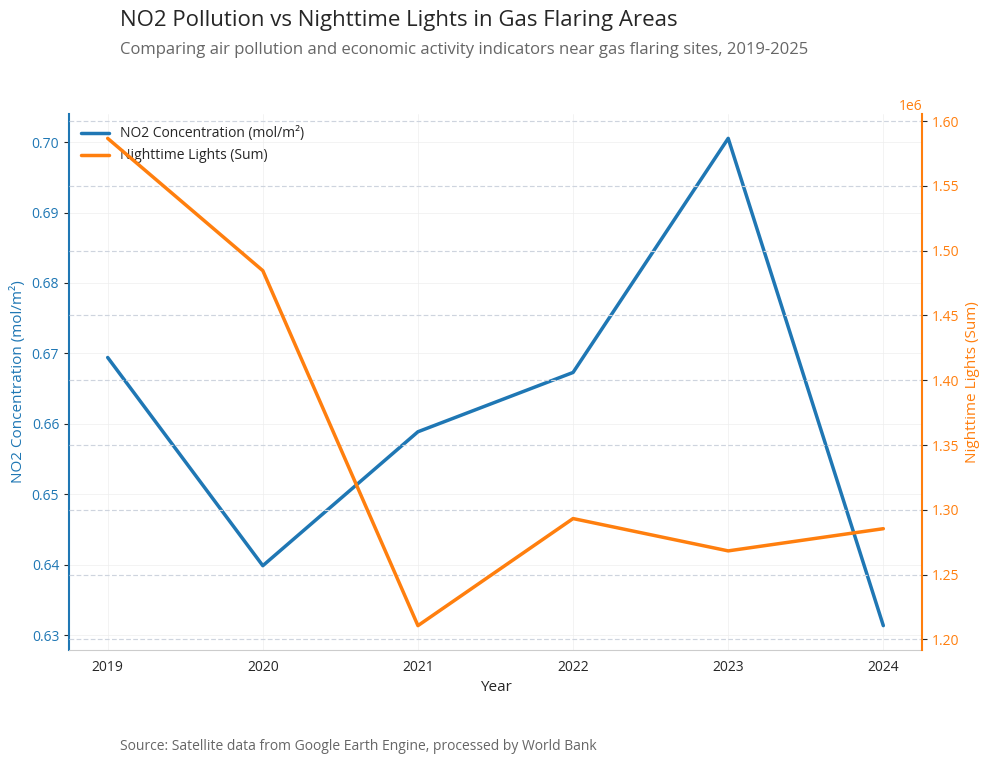

In [652]:
# Merge NTL and NO2 data for gas flaring areas
# First, ensure both datasets have matching year columns
ntl_gf = ntl_adm0_annual[ntl_adm0_annual['date']>=2019].copy()
ntl_gf = ntl_gf.rename(columns={'date': 'year'})

# Merge on year
dual_axis_data = no2_gas_flaring_adm0.merge(
    ntl_gf[['year', 'ntl_gf_10km_sum']], 
    on='year', 
    how='inner'
)

# Create dual axis plot with World Bank colors
plot_wb_styled_dual_axis(
    data=dual_axis_data,
    x_column='year',
    y1_column='NO2_sum',
    y2_column='ntl_gf_10km_sum',
    category_column=None,  # No grouping, just single lines
    y1_label='NO2 Concentration (mol/m²)',
    y2_label='Nighttime Lights (Sum)',
    title='NO2 Pollution vs Nighttime Lights in Gas Flaring Areas',
    subtitle='Comparing air pollution and economic activity indicators near gas flaring sites, 2019-2025',
    source_note='Satellite data from Google Earth Engine, processed by World Bank',
    figsize=(10, 8),
    y1_color='#1f77b4',  # World Bank Blue
    y2_color='#ff7f0e'   # World Bank Orange
);

Creating subplots for 11 categories


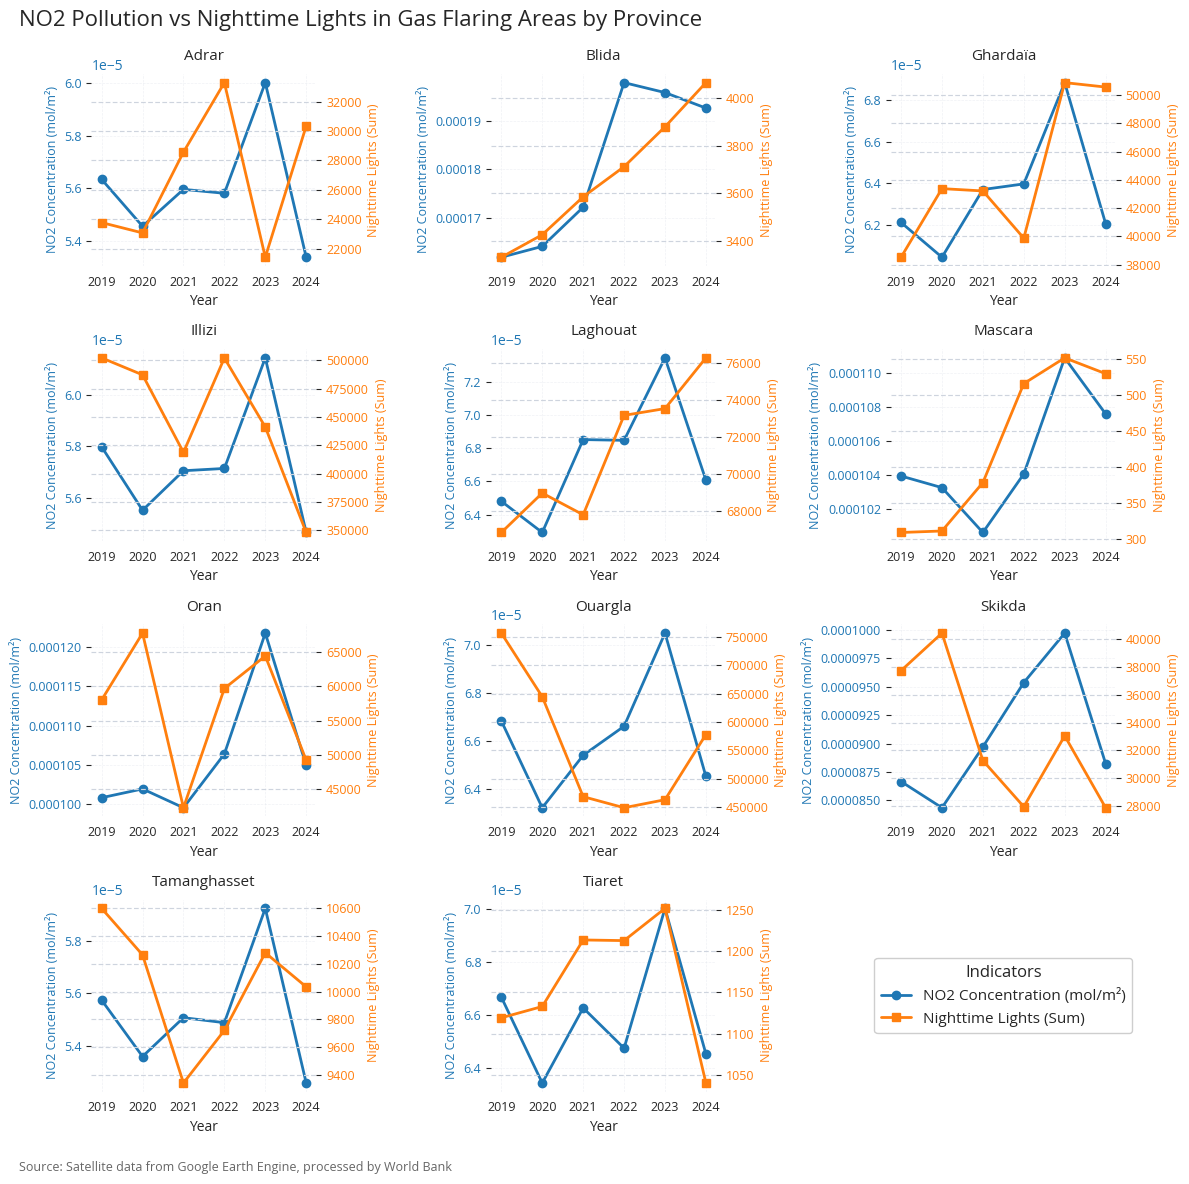

In [679]:
# Create subplots for each province showing NO2 vs Nighttime Lights
# Merge NTL and NO2 data for gas flaring areas at ADM1 level
ntl_gf_adm1 = ntl_adm1_annual[ntl_adm1_annual['date']>=2019].copy()
ntl_gf_adm1 = ntl_gf_adm1.rename(columns={'date': 'year'})

# Merge on year and NAME_1 (province)
dual_axis_data_adm1 = no2_gas_flaring_adm1.merge(
    ntl_gf_adm1[['year', 'NAME_1', 'ntl_gf_10km_sum']], 
    on=['year', 'NAME_1'], 
    how='inner'
)

# Use the new subplot function
plot_dual_axis_subplots_by_category(
    data=dual_axis_data_adm1,
    category_column='NAME_1',
    x_column='year',
    y1_column='NO2_mean',
    y2_column='ntl_gf_10km_sum',
    y1_label='NO2 Concentration (mol/m²)',
    y2_label='Nighttime Lights (Sum)',
    title='NO2 Pollution vs Nighttime Lights in Gas Flaring Areas by Province',
    subtitle='',
    source_note='Source: Satellite data from Google Earth Engine, processed by World Bank',
    y1_color='#1f77b4',  # World Bank Blue
    y2_color='#ff7f0e',  # World Bank Orange
    n_cols=3,
    figsize_per_plot=(4, 3)
);